## import & load

In [70]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

from collections import defaultdict
import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')

In [40]:
import data.read
importlib.reload(data.read)

<module 'data.read' from '/home/junlim/projects/jitter_recovery/data/read.py'>

In [41]:
df = data.read.df_okx_20240103_0104.dropna()
#df = data.read.df_okx_20240101_0131.dropna()
#df = data.read.df_okx_20240203_0205.dropna()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])
all_symbols = df.symbol.unique()

In [42]:
df.tail(3)

,timestamp,symbol,open,high,low,close,volume
261217,2024-01-04 04:58:00,GAS-USDT-SWAP,6.201,6.201,6.192,6.192,266.000
261218,2024-01-04 04:58:00,RNDR-USDT-SWAP,4.481,4.481,4.479,4.479,61.000
261219,2024-01-04 04:58:00,YFI-USDT-SWAP,7612.000,7612.000,7607.000,7607.000,0.056


In [43]:
all_symbols = [s for s in all_symbols if s]

In [44]:
len([s for s in all_symbols if 'USDT' in s])

153

## multiple symbols

In [402]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.calculate_collective
importlib.reload(algo.jitter_recovery.calculate_collective)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)
import algo.jitter_recovery.research_collective
importlib.reload(algo.jitter_recovery.research_collective)

<module 'algo.jitter_recovery.research_collective' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research_collective.py'>

In [403]:
def add_trading_columns(df_feature, df_collective_feature_approxiamate, trading_param):
    status = algo.jitter_recovery.calculate_collective.Status()
    trading_dict = defaultdict(list)

    for i in df_feature.index:
        features = df_feature.loc[i].to_dict()
        if i in df_collective_feature_approxiamate.index:
            collective_featuers = df_collective_feature_approxiamate.loc[i].to_dict()
        else:
            collective_featuers = {c: 0.0 for c in collective_feature_columns}
        all_features = {**features, **collective_featuers}
        status.update(collective_featuers, features, trading_param)
        for k, v in {**all_features, **algo.jitter_recovery.calculate.status_as_dict(status)}.items():
            trading_dict[k].append(v)

    df_feature_trading = pd.DataFrame(trading_dict, index=df_feature.index)
    df_feature_trading['position_changed'] = df_feature_trading.in_position.diff()
    df_feature_trading['profit_raw'] = df_feature_trading.value.diff() * df_feature_trading.in_position.shift()
    df_feature_trading['profit'] = df_feature_trading.value.pct_change() * df_feature_trading.in_position.shift()

    return df_feature_trading


In [404]:
collective_feature_columns_no_rolling = ['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min']
collective_feature_columns = collective_feature_columns_no_rolling + ['ch_window30_min']

def get_dfsts(df, trading_param):
    dfi = df.set_index(['timestamp', 'symbol'])
    all_symbols = df.symbol.unique()
    all_symbols = [s for s in all_symbols if 'USDT' in s]

    initial_run_resolution = 4

    window_ = int(trading_param.feature_param.window / initial_run_resolution)
    dfst_feature_approximate = None
    symbol_with_drops = []


    for i, symbol in enumerate(all_symbols[:10]):
        if 'USDT' not in symbol: continue
        dfs = dfi.xs(symbol, level=1)
        dfs_ = dfs.resample(f'{initial_run_resolution}min').last()
        feature_param_ = algo.jitter_recovery.calculate_collective.CollectiveRecoveryFeatureParam(window_)
        
        df_feature_ = algo.jitter_recovery.calculate.get_feature_df(dfs_, feature_param_)
        del dfs
        del dfs_
        
        print(f'{i} symbol: {symbol}: {len(df_feature_[df_feature_.ch_min <= trading_param.drop_threshold * 0.9])} (approx)')
        if len(df_feature_[df_feature_.ch_min <= trading_param.drop_threshold * 0.9]) > 0:
            symbol_with_drops.append(symbol)
        
        df_feature_['symbol'] = symbol
        if dfst_feature_approximate is None:
            dfst_feature_approximate = df_feature_.copy()
        else:
            dfst_feature_approximate = pd.concat([dfst_feature_approximate, df_feature_])

        del df_feature_

    dfst_feature_approximate = dfst_feature_approximate.reset_index().set_index(['symbol', 'timestamp'])
    df_collective_feature_approxiamate = dfst_feature_approximate.dropna().groupby('timestamp')[collective_feature_columns_no_rolling].median().resample('1min').asfreq().ffill()
    df_collective_feature_approxiamate['ch_window30_min'] = df_collective_feature_approxiamate.ch.rolling(window=60).min() 

    
    for i, symbol in enumerate(all_symbols):
        if 'USDT' not in symbol: continue
        if 'CEL' not in symbol: continue
        dfs = dfi.xs(symbol, level=1)
        
        df_feature = algo.jitter_recovery.calculate.get_feature_df(dfs, trading_param.feature_param)
        del dfs

        print(f'{i} symbol: {symbol}: {len(df_feature[df_feature.ch_min <= trading_param.drop_threshold * 0.9])}')
        df_trading = add_trading_columns(df_feature, df_collective_feature_approxiamate, trading_param)

        for column in df_feature.columns:
            dfst_feature.loc[symbol, column] = df_feature[column].values

        for column in df_trading.columns:
            dfst_trading.loc[symbol, column] = df_trading[column].values

        del df_feature
        del df_trading

    return dfst_feature_approximate, dfst_feature, dfst_trading

In [405]:
print(str(trading_param))

feature_param: window: 40, drop_threshold: -0.15, jump_from_drop_threshold: 0.04, exit_drop_threshold: -0.02


In [406]:
feature_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryFeatureParam(40)
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.15, +0.04, -0.02)

In [407]:
dfst_feature_approximate, dfst_feature, dfst_trading = algo.jitter_recovery.research_collective.get_dfsts(df, trading_param)

0 symbol: STX-USDT-SWAP: 0 (approx)
1 symbol: LUNC-USDT-SWAP: 9 (approx)
2 symbol: MINA-USDT-SWAP: 7 (approx)
3 symbol: EGLD-USDT-SWAP: 8 (approx)
4 symbol: SNX-USDT-SWAP: 7 (approx)
5 symbol: GMT-USDT-SWAP: 7 (approx)
6 symbol: OP-USDT-SWAP: 7 (approx)
7 symbol: JST-USDT-SWAP: 0 (approx)
8 symbol: DYDX-USDT-SWAP: 9 (approx)
9 symbol: BNB-USDT-SWAP: 0 (approx)
10 symbol: MAGIC-USDT-SWAP: 9 (approx)
11 symbol: OMG-USDT-SWAP: 8 (approx)
12 symbol: FITFI-USDT-SWAP: 9 (approx)
13 symbol: PERP-USDT-SWAP: 9 (approx)
14 symbol: FRONT-USDT-SWAP: 1 (approx)
15 symbol: MANA-USDT-SWAP: 7 (approx)
16 symbol: EOS-USDT-SWAP: 4 (approx)
17 symbol: ANT-USDT-SWAP: 0 (approx)
18 symbol: LRC-USDT-SWAP: 9 (approx)
19 symbol: 1INCH-USDT-SWAP: 8 (approx)
20 symbol: CTC-USDT-SWAP: 9 (approx)
21 symbol: TRB-USDT-SWAP: 9 (approx)
22 symbol: TRX-USDT-SWAP: 0 (approx)
23 symbol: GFT-USDT-SWAP: 7 (approx)
24 symbol: SSV-USDT-SWAP: 9 (approx)
25 symbol: MKR-USDT-SWAP: 9 (approx)
26 symbol: ATOM-USDT-SWAP: 8 (appro

In [410]:
df_collective_feature_approxiamate = dfst_feature_approximate.dropna().groupby('timestamp')[collective_feature_columns_no_rolling].median().resample('1min').asfreq().ffill()
df_collective_feature_approxiamate['ch_window30_min'] = df_collective_feature_approxiamate.ch.rolling(window=60).min() 

<Axes: xlabel='timestamp'>

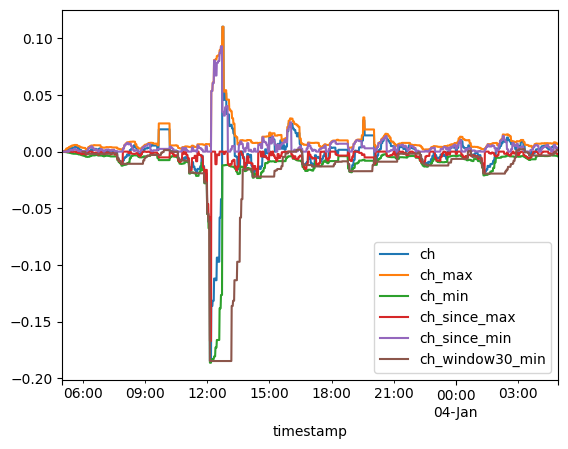

In [411]:
df_collective_feature_approxiamate.plot()

<Axes: xlabel='timestamp'>

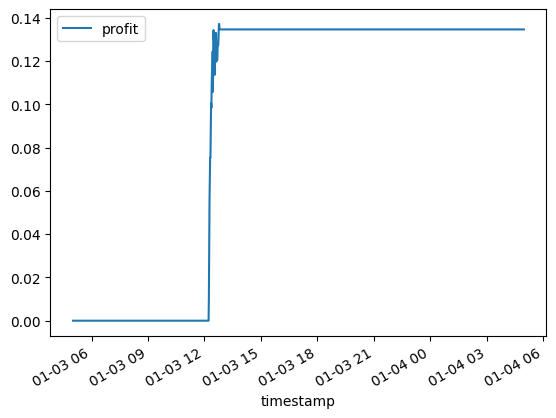

In [412]:
dfst_trading.xs('CEL-USDT-SWAP', level=0)[['profit']].dropna().cumsum().plot()

<Axes: xlabel='timestamp'>

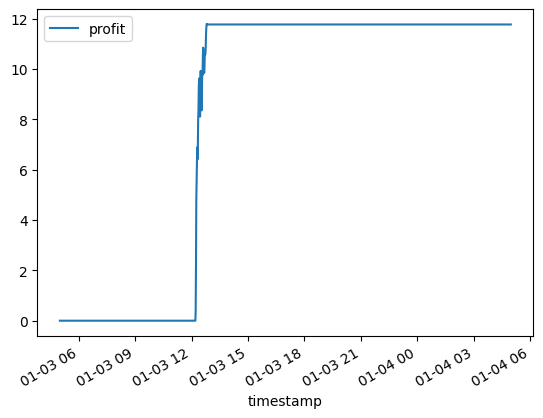

In [413]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot()

In [219]:
df_feature = algo.jitter_recovery.calculate.get_feature_df(dfst_feature.xs('CEL-USDT-SWAP', level=0), trading_param.jitter_recovery_feature_param)

In [220]:
df_trading = add_trading_columns(
    df_feature, 
    df_collective_feature_approxiamate, collective_trading_param)

<Axes: xlabel='timestamp'>

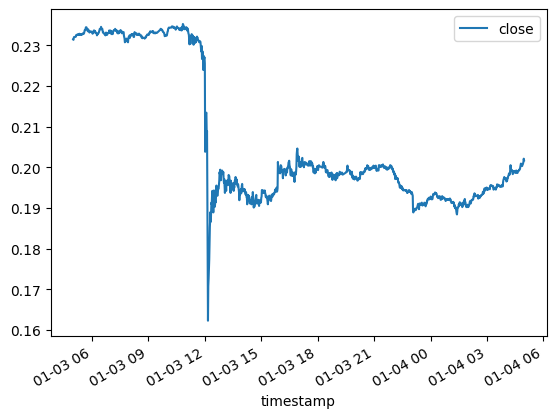

In [221]:
dfst_feature.xs('CEL-USDT-SWAP', level=0)[['close']].plot()

<Axes: xlabel='timestamp'>

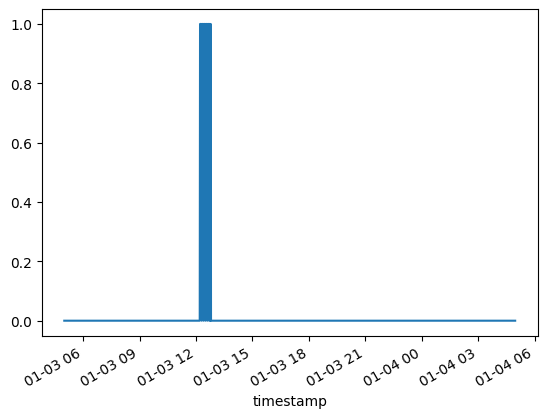

In [222]:
df_trading.in_position.plot()

<Axes: xlabel='timestamp'>

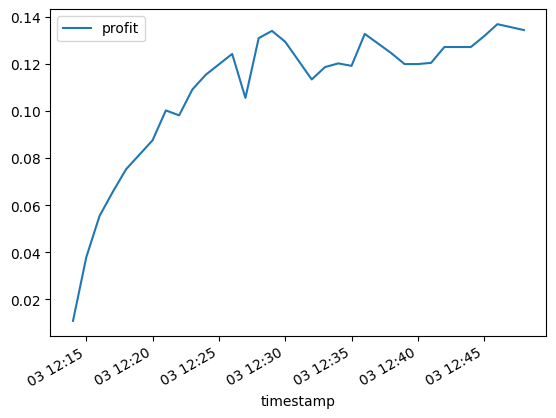

In [223]:
df_trading[(df_trading.in_position.shift() != 0)][['profit']].cumsum().plot()

<Axes: xlabel='timestamp'>

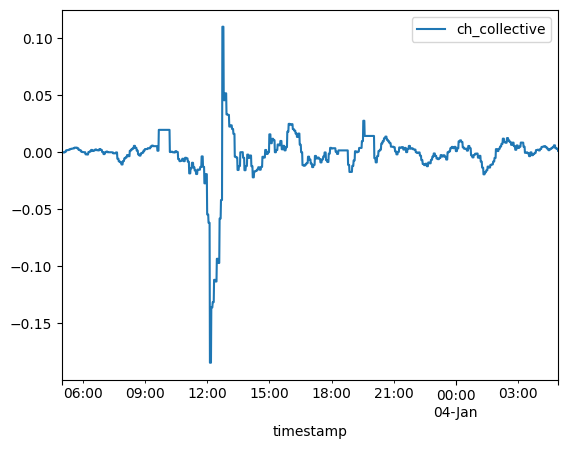

In [81]:
df_collective_feature_approxiamate[['ch_collective']].plot()

<Axes: xlabel='timestamp'>

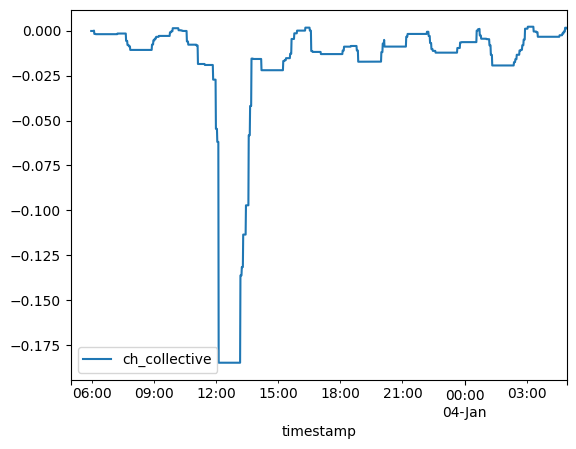

In [86]:
df_collective_feature_approxiamate[['ch_collective']].rolling(window=60).min().plot()

KeyError: "None of [Index(['profit'], dtype='object')] are in the [columns]"

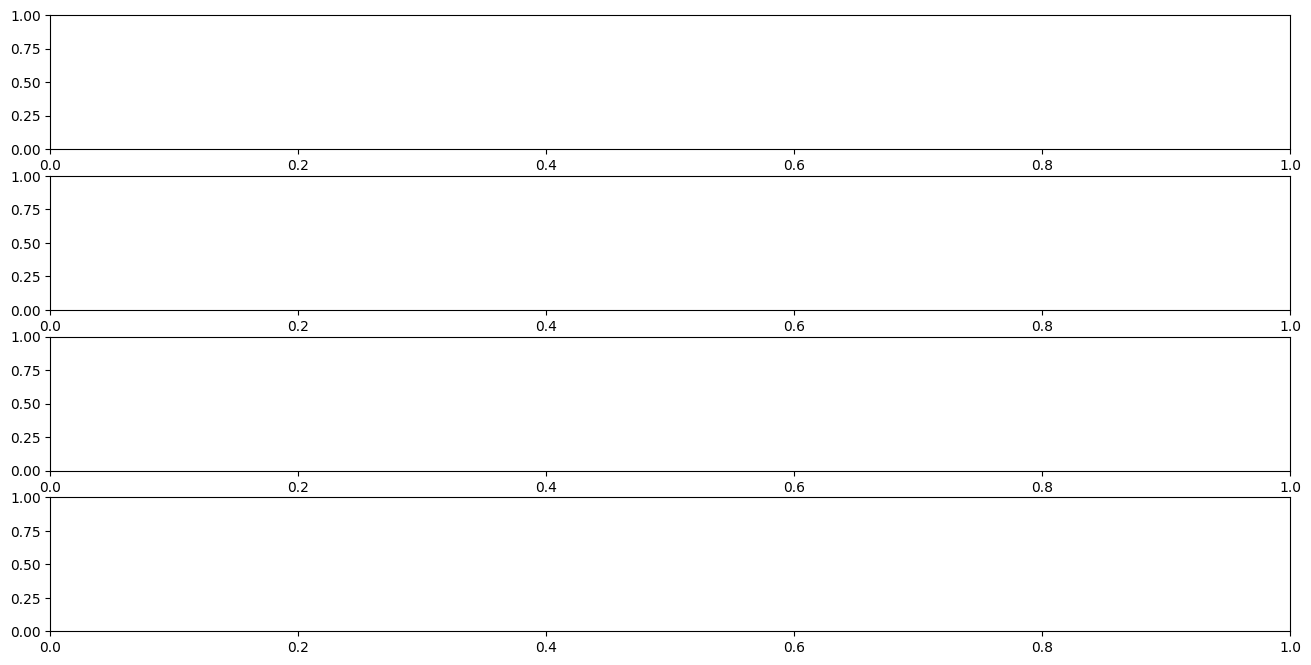

In [24]:
algo.jitter_recovery.research_collective.investigate_trading(dfst_feature_approximate, dfst_trading)

In [24]:
df_collective_feature_approxiamate[
    df_collective_feature_approxiamate.ch_collective  < -0.05
]

,ch_collective,ch_max_collective,ch_min_collective,ch_since_max_collective,ch_since_min_collective
timestamp,,,,,
2023-12-11 02:12:00,-0.075790,0.004435,-0.079180,-0.078807,0.000000
2023-12-11 02:13:00,-0.075790,0.004435,-0.079180,-0.078807,0.000000
2023-12-11 02:14:00,-0.075790,0.004435,-0.079180,-0.078807,0.000000
2023-12-11 02:15:00,-0.075790,0.004435,-0.079180,-0.078807,0.000000
2023-12-11 02:16:00,-0.067052,0.009235,-0.079120,0.000000,0.008735
2023-12-11 02:17:00,-0.067052,0.009235,-0.079120,0.000000,0.008735
2023-12-11 02:18:00,-0.067052,0.009235,-0.079120,0.000000,0.008735
2023-12-11 02:19:00,-0.067052,0.009235,-0.079120,0.000000,0.008735
2023-12-11 02:20:00,-0.064955,0.013639,-0.079120,0.000000,0.013639


<Axes: xlabel='timestamp'>

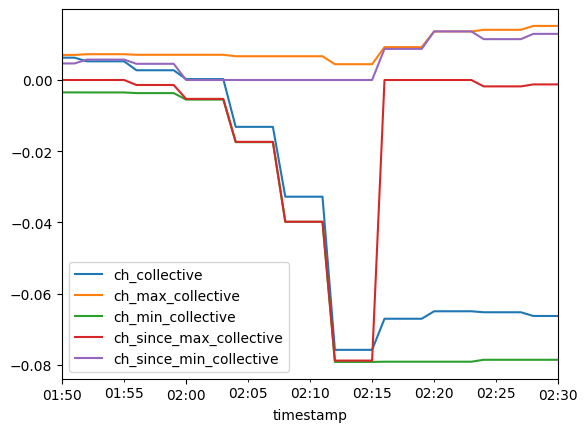

In [15]:
df_collective_feature_approxiamate.loc['2023-12-11 01:50:00':'2023-12-11 02:30:00'].plot()

In [16]:
dfst_feature.loc[
    (dfst_feature.index.get_level_values('timestamp') == '2023-12-11 02:12:00')
][['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch', 'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from', 'v_ch_min_is_to']].dropna()

,,ch,ch_max,ch_min,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,v_ch_max_is_from,v_ch_max_is_to,v_ch_min_is_from,v_ch_min_is_to
symbol,timestamp,,,,,,,,,,,
ORDI-USDT-SWAP,2023-12-11 02:12:00,-0.132991,0.007496,-0.135800,-0.133724,0.0,16.0,0.0,50.428000,50.806000,50.928000,44.012000
WSM-USDT-SWAP,2023-12-11 02:12:00,-0.090114,0.008423,-0.091496,-0.091496,0.0,18.0,0.0,0.026120,0.026340,0.026340,0.023930
TRB-USDT-SWAP,2023-12-11 02:12:00,-0.020641,0.020346,-0.038708,-0.038708,0.0,3.0,0.0,91.910000,93.780000,93.780000,90.150000
BADGER-USDT-SWAP,2023-12-11 02:12:00,-0.162433,0.009121,-0.167092,-0.167092,0.0,16.0,0.0,4.276000,4.315000,4.315000,3.594000
FLOKI-USDT-SWAP,2023-12-11 02:12:00,-0.106447,0.021799,-0.123100,-0.123100,0.0,16.0,0.0,0.000040,0.000041,0.000041,0.000036
BIGTIME-USDT-SWAP,2023-12-11 02:12:00,-0.214293,0.070473,-0.247661,-0.247661,0.0,18.0,0.0,0.635700,0.680500,0.680500,0.511967
CSPR-USDT-SWAP,2023-12-11 02:12:00,-0.066165,0.007171,-0.066165,-0.059945,0.0,33.0,0.0,0.043230,0.043540,0.043830,0.040930
SWEAT-USDT-SWAP,2023-12-11 02:12:00,-0.057346,0.006659,-0.063415,-0.063415,0.0,14.0,0.0,0.011263,0.011338,0.011338,0.010619
YFII-USDT-SWAP,2023-12-11 02:12:00,-0.096888,0.008162,-0.099210,-0.099210,0.0,15.0,0.0,1543.700000,1556.300000,1556.300000,1401.900000


<Axes: xlabel='timestamp'>

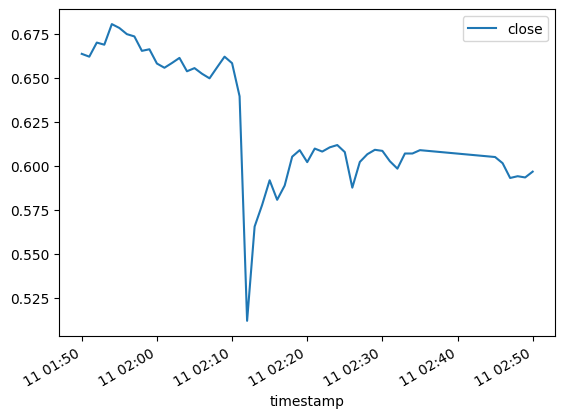

In [23]:
dfi.xs('BIGTIME-USDT-SWAP', level=1).loc['2023-12-11 01:50:00':'2023-12-11 02:50:00'][['close']].plot()

<Axes: xlabel='timestamp'>

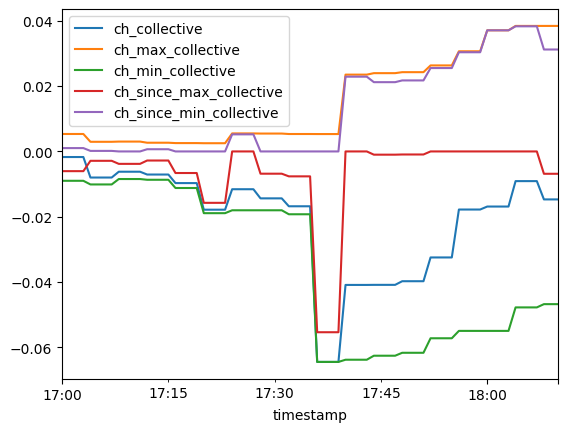

In [26]:
df_collective_feature_approxiamate.loc['2023-12-26 17:00:00':'2023-12-26 18:10:00'].plot()

In [46]:
dfst_feature.loc[
    (dfst_feature.index.get_level_values('timestamp') == '2023-12-26 17:39:00')
][['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch', 'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from', 'v_ch_min_is_to']].dropna()

,,ch,ch_max,ch_min,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,v_ch_max_is_from,v_ch_max_is_to,v_ch_min_is_from,v_ch_min_is_to
symbol,timestamp,,,,,,,,,,,
BADGER-USDT-SWAP,2023-12-26 17:39:00,-0.072522,0.008270,-0.073138,-0.072933,0.0,26.0,0.0,4.474000,4.511000,4.512000,4.182000
CETUS-USDT-SWAP,2023-12-26 17:39:00,-0.187481,0.008582,-0.187806,-0.186587,0.0,31.0,0.0,0.099050,0.099900,0.100050,0.081260
YFII-USDT-SWAP,2023-12-26 17:39:00,-0.082844,0.006587,-0.083477,-0.069876,0.0,10.0,0.0,850.200000,855.800000,868.500000,796.000000
SWEAT-USDT-SWAP,2023-12-26 17:39:00,-0.033798,0.003434,-0.033798,-0.028681,0.0,11.0,0.0,0.012231,0.012273,0.012338,0.011921
CSPR-USDT-SWAP,2023-12-26 17:39:00,-0.030042,0.006615,-0.030719,-0.022530,0.0,10.0,0.0,0.042330,0.042610,0.042970,0.041650
FLOKI-USDT-SWAP,2023-12-26 17:39:00,-0.066909,0.005401,-0.068474,-0.057676,0.0,14.0,0.0,0.000035,0.000035,0.000036,0.000033
WSM-USDT-SWAP,2023-12-26 17:39:00,-0.081671,0.002793,-0.082522,-0.081244,0.0,26.0,0.0,0.021480,0.021540,0.021570,0.019790
TURBO-USDT-SWAP,2023-12-26 17:39:00,-0.184752,0.011093,-0.186557,-0.178789,0.0,12.0,0.0,0.000487,0.000492,0.000497,0.000404
TRB-USDT-SWAP,2023-12-26 17:39:00,-0.028218,0.004040,-0.029939,-0.029939,0.0,26.0,0.0,185.630000,186.380000,186.380000,180.800000


<Axes: xlabel='timestamp'>

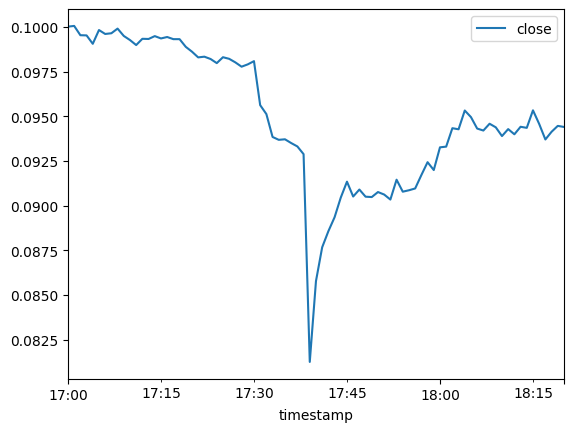

In [47]:
dfi.xs('CETUS-USDT-SWAP', level=1).loc['2023-12-26 17:00:00':'2023-12-26 18:20:00'][['close']].plot()

<Axes: xlabel='timestamp'>

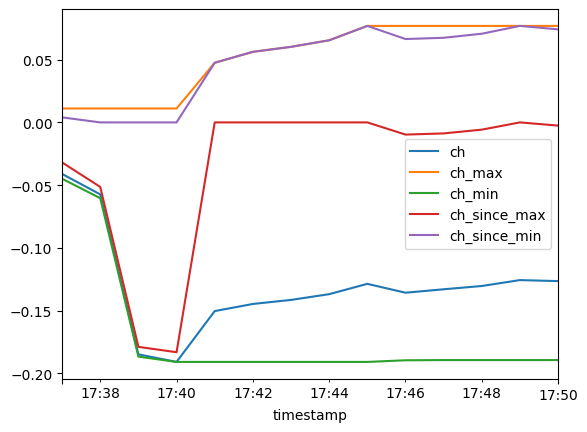

In [45]:
dfst_feature.loc[
    (dfst_feature.index.get_level_values('symbol') == 'TURBO-USDT-SWAP')
    & (dfst_feature.index.get_level_values('timestamp') >= '2023-12-26 17:37:00')
    & (dfst_feature.index.get_level_values('timestamp') <= '2023-12-26 17:50:00')
][['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch', 'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from', 'v_ch_min_is_to']].dropna()\
.reset_index().set_index('timestamp')\
[['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min']].plot()

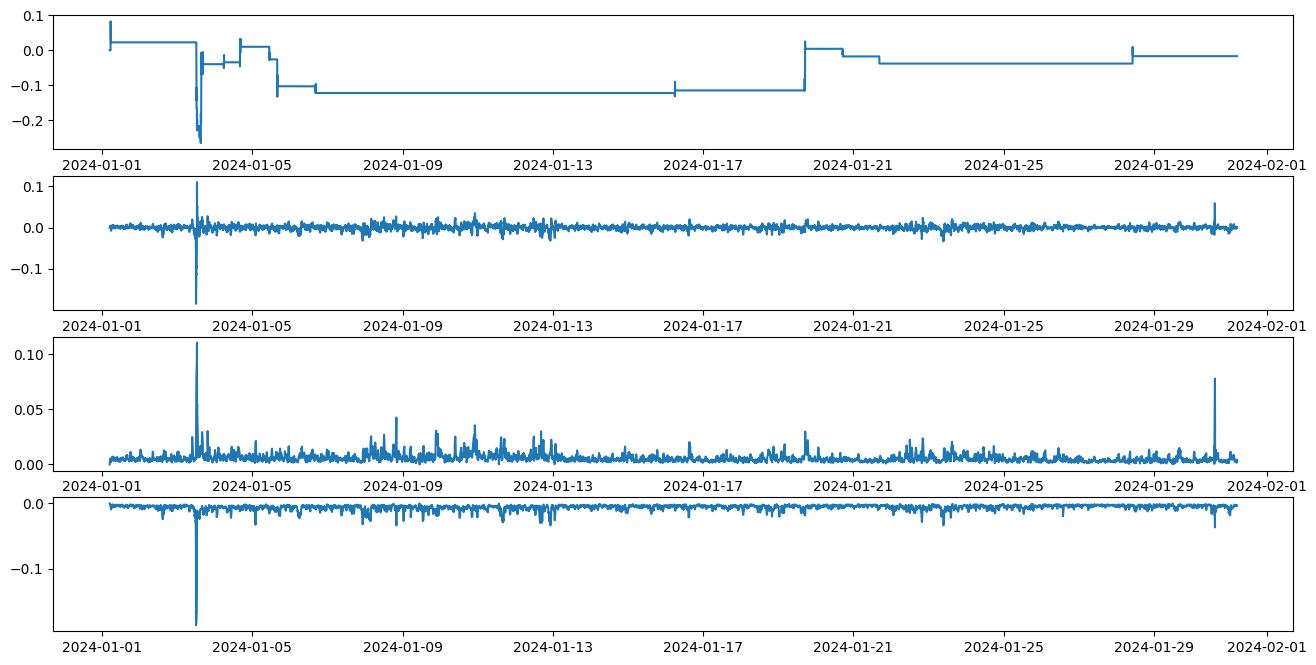

In [11]:
algo.jitter_recovery.research.investigate_trading(dfst_feature_approximate, dfst_trading)

In [ ]:
df_collective_feature_approxiamate[
    df_collective_feature_approxiamate.ch_collective  < -0.1
]

<Axes: xlabel='timestamp'>

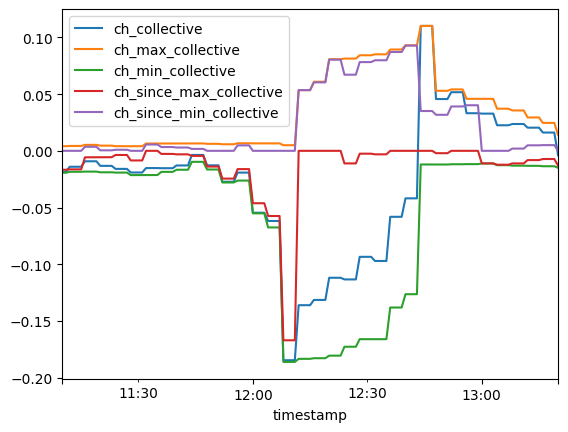

In [36]:
df_collective_feature_approxiamate.loc['2024-01-03 11:10:00':'2024-01-03 13:20:00'].plot()

In [49]:
dfst_feature.loc[
    (dfst_feature.index.get_level_values('timestamp') == '2024-01-03 12:20:00')
][['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch', 'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from', 'v_ch_min_is_to']].dropna()

,,ch,ch_max,ch_min,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,v_ch_max_is_from,v_ch_max_is_to,v_ch_min_is_from,v_ch_min_is_to
symbol,timestamp,,,,,,,,,,,
CEL-USDT-SWAP,2024-01-03 12:20:00,-0.182605,0.164510,-0.297707,-0.000529,0.163894,2.0,10.0,0.162300,0.189000,0.231100,0.162300
API3-USDT-SWAP,2024-01-03 12:20:00,-0.130994,0.098574,-0.209701,-0.007901,0.089895,2.0,10.0,1.613000,1.772000,2.041000,1.613000
YGG-USDT-SWAP,2024-01-03 12:20:00,-0.180716,0.142627,-0.297155,-0.001173,0.141287,2.0,10.0,0.373000,0.426200,0.530700,0.373000
TIA-USDT-SWAP,2024-01-03 12:20:00,-0.109267,0.208404,-0.260541,-0.003169,0.204574,2.0,10.0,9.400000,11.359000,12.712000,9.400000
MEME-USDT-SWAP,2024-01-03 12:20:00,-0.194624,0.171786,-0.315639,-0.001777,0.169703,2.0,9.0,0.019210,0.022510,0.028070,0.019210
ARB-USDT-SWAP,2024-01-03 12:20:00,-0.072653,0.215339,-0.226107,-0.014029,0.198288,2.0,11.0,1.472100,1.789100,1.902200,1.472100
LUNA-USDT-SWAP,2024-01-03 12:20:00,-0.196770,0.226543,-0.345832,-0.000595,0.225812,2.0,10.0,0.547800,0.671900,0.837400,0.547800
RACA-USDT-SWAP,2024-01-03 12:20:00,-0.136443,0.247737,-0.291958,-0.023087,0.218930,3.0,9.0,0.000121,0.000152,0.000172,0.000121
FITFI-USDT-SWAP,2024-01-03 12:20:00,-0.285086,0.053820,-0.286102,-0.109554,0.000000,4.0,0.0,0.005890,0.006207,0.007742,0.005527


<Axes: xlabel='timestamp'>

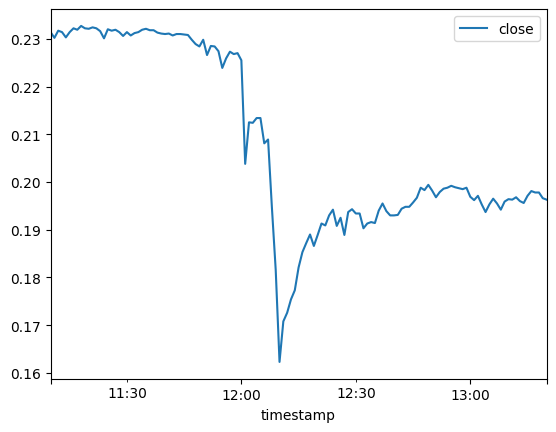

In [47]:
dfi.xs('CEL-USDT-SWAP', level=1).loc['2024-01-03 11:10:00':'2024-01-03 13:20:00'][['close']].plot()

In [44]:
df_collective_feature_approxiamate[
    df_collective_feature_approxiamate.ch_collective  > 0.05
]

,ch_collective,ch_max_collective,ch_min_collective,ch_since_max_collective,ch_since_min_collective
timestamp,,,,,
2024-01-03 12:44:00,0.110184,0.110184,-0.012037,0.0,0.035116
2024-01-03 12:45:00,0.110184,0.110184,-0.012037,0.0,0.035116
2024-01-03 12:46:00,0.110184,0.110184,-0.012037,0.0,0.035116
2024-01-03 12:47:00,0.110184,0.110184,-0.012037,0.0,0.035116
2024-01-03 12:52:00,0.051724,0.054185,-0.011835,0.0,0.039143
2024-01-03 12:53:00,0.051724,0.054185,-0.011835,0.0,0.039143
2024-01-03 12:54:00,0.051724,0.054185,-0.011835,0.0,0.039143
2024-01-03 12:55:00,0.051724,0.054185,-0.011835,0.0,0.039143
2024-01-30 14:48:00,0.058788,0.077730,-0.018171,0.0,0.077730


<Axes: xlabel='timestamp'>

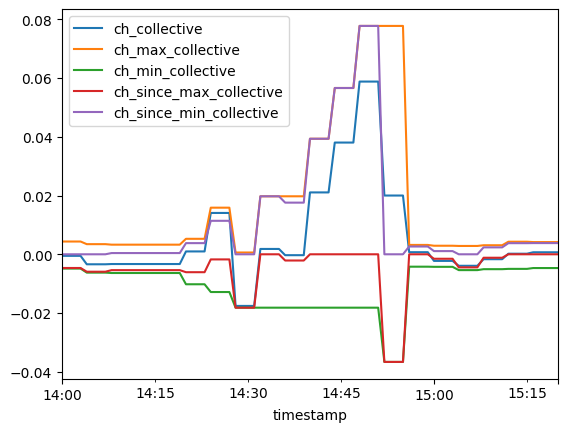

In [46]:
df_collective_feature_approxiamate.loc['2024-01-30 14:00:00':'2024-01-30 15:20:00'].plot()

In [58]:
dfst_feature.loc[
    (dfst_feature.index.get_level_values('timestamp') == '2024-01-30 14:49:00')
][['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch', 'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from', 'v_ch_min_is_to']].dropna()

,,ch,ch_max,ch_min,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,v_ch_max_is_from,v_ch_max_is_to,v_ch_min_is_from,v_ch_min_is_to
symbol,timestamp,,,,,,,,,,,
LDO-USDT-SWAP,2024-01-30 14:49:00,0.003683,0.010410,-0.005317,-0.003656,0.001671,16.0,8.0,2.978000,3.009000,3.009000,2.993000
YGG-USDT-SWAP,2024-01-30 14:49:00,0.006091,0.009354,-0.004957,-0.003233,0.001733,23.0,8.0,0.459700,0.464000,0.464000,0.461700
VRA-USDT-SWAP,2024-01-30 14:49:00,0.013652,0.031475,-0.018199,-0.017279,0.000936,30.0,1.0,0.005274,0.005440,0.005440,0.005341
CFX-USDT-SWAP,2024-01-30 14:49:00,-0.016724,0.005204,-0.016724,-0.010785,0.000000,16.0,0.0,0.230600,0.231800,0.233200,0.229300
PEOPLE-USDT-SWAP,2024-01-30 14:49:00,0.004745,0.012436,-0.005780,-0.005419,0.000363,16.0,1.0,0.027340,0.027680,0.027680,0.027520
TRB-USDT-SWAP,2024-01-30 14:49:00,0.004880,0.010649,-0.005528,-0.003973,0.001563,22.0,8.0,114.560000,115.780000,115.780000,115.140000
LUNA-USDT-SWAP,2024-01-30 14:49:00,-0.012930,0.008211,-0.013554,-0.007674,0.000632,23.0,8.0,0.633300,0.638500,0.641900,0.633200
RACA-USDT-SWAP,2024-01-30 14:49:00,0.001361,0.008191,-0.004062,-0.004062,0.000000,23.0,0.0,0.000147,0.000148,0.000148,0.000147
TIA-USDT-SWAP,2024-01-30 14:49:00,0.002034,0.013312,-0.010423,-0.010423,0.000000,23.0,0.0,18.179000,18.421000,18.421000,18.229000


<Axes: xlabel='timestamp'>

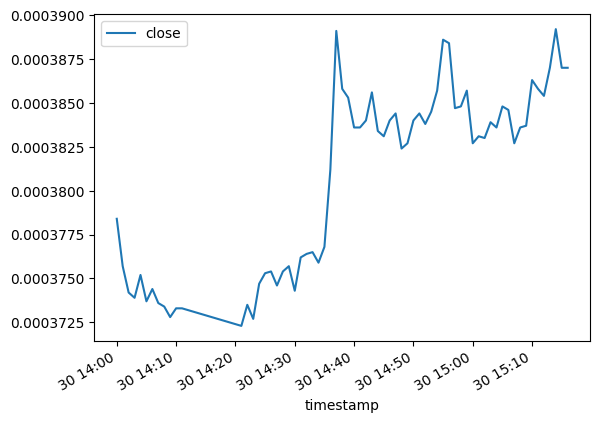

In [59]:
dfi.xs('TURBO-USDT-SWAP', level=1).loc['2024-01-30 14:00:00':'2024-01-30 15:20:00'][['close']].plot()

In [40]:
len(dfst_feature.loc[
    (dfst_feature.index.get_level_values('timestamp') == '2024-01-03 12:20:00')
][['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch', 'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from', 'v_ch_min_is_to']].dropna().reset_index().symbol.unique())

34

In [26]:
dfst_feature.loc[
    (dfst_feature.index.get_level_values('timestamp') == '2024-01-03 12:20:00')
][['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch', 'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from', 'v_ch_min_is_to']].dropna()

,,ch,ch_max,ch_min,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,v_ch_max_is_from,v_ch_max_is_to,v_ch_min_is_from,v_ch_min_is_to
symbol,timestamp,,,,,,,,,,,
CEL-USDT-SWAP,2024-01-03 12:20:00,-0.182605,0.164510,-0.297707,-0.000529,0.163894,2.0,10.0,0.162300,0.189000,0.231100,0.162300
API3-USDT-SWAP,2024-01-03 12:20:00,-0.130994,0.098574,-0.209701,-0.007901,0.089895,2.0,10.0,1.613000,1.772000,2.041000,1.613000
YGG-USDT-SWAP,2024-01-03 12:20:00,-0.180716,0.142627,-0.297155,-0.001173,0.141287,2.0,10.0,0.373000,0.426200,0.530700,0.373000
TIA-USDT-SWAP,2024-01-03 12:20:00,-0.109267,0.208404,-0.260541,-0.003169,0.204574,2.0,10.0,9.400000,11.359000,12.712000,9.400000
MEME-USDT-SWAP,2024-01-03 12:20:00,-0.194624,0.171786,-0.315639,-0.001777,0.169703,2.0,9.0,0.019210,0.022510,0.028070,0.019210
ARB-USDT-SWAP,2024-01-03 12:20:00,-0.072653,0.215339,-0.226107,-0.014029,0.198288,2.0,11.0,1.472100,1.789100,1.902200,1.472100
LUNA-USDT-SWAP,2024-01-03 12:20:00,-0.196770,0.226543,-0.345832,-0.000595,0.225812,2.0,10.0,0.547800,0.671900,0.837400,0.547800
RACA-USDT-SWAP,2024-01-03 12:20:00,-0.136443,0.247737,-0.291958,-0.023087,0.218930,3.0,9.0,0.000121,0.000152,0.000172,0.000121
FITFI-USDT-SWAP,2024-01-03 12:20:00,-0.285086,0.053820,-0.286102,-0.109554,0.000000,4.0,0.0,0.005890,0.006207,0.007742,0.005527


<Axes: xlabel='timestamp'>

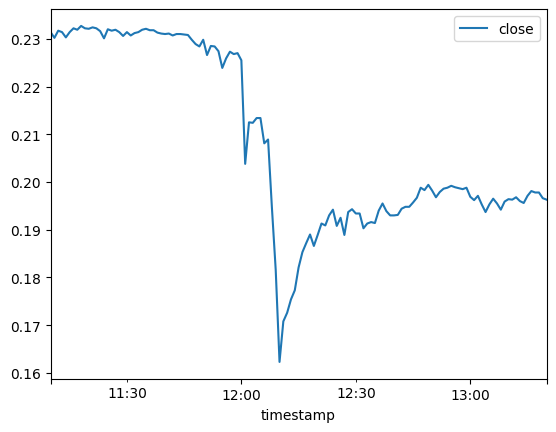

In [37]:
dfi.xs('CEL-USDT-SWAP', level=1).loc['2024-01-03 11:10:00':'2024-01-03 13:20:00'][['close']].plot()

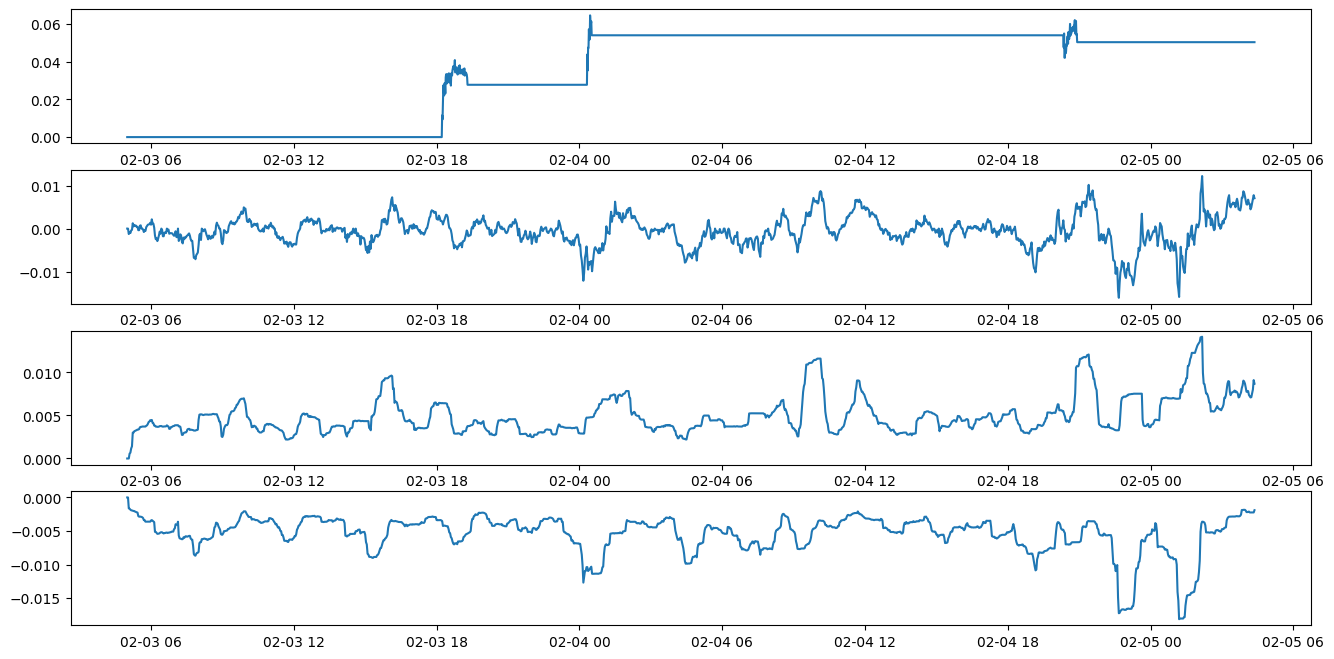

In [399]:
algo.jitter_recovery.research.investigate_trading(dfst_feature_approximate, dfst_trading)

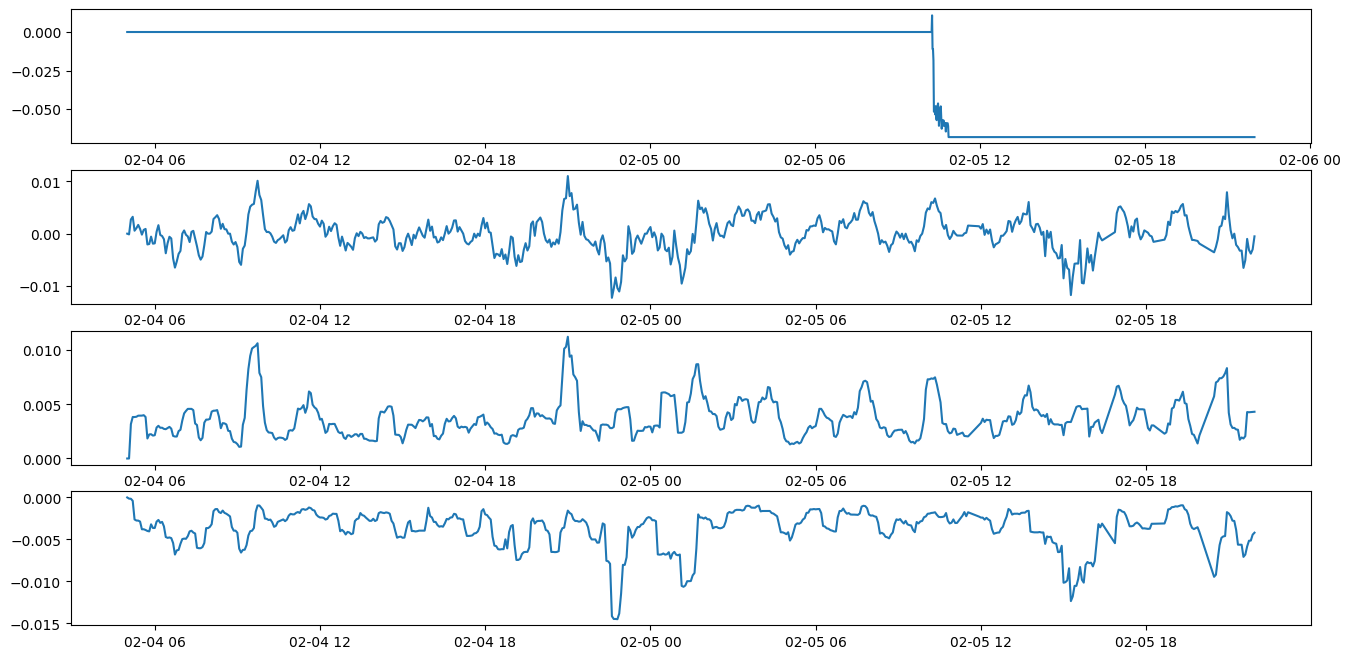

In [146]:
algo.jitter_recovery.research.investigate_trading(dfst_feature_approximate, dfst_trading)

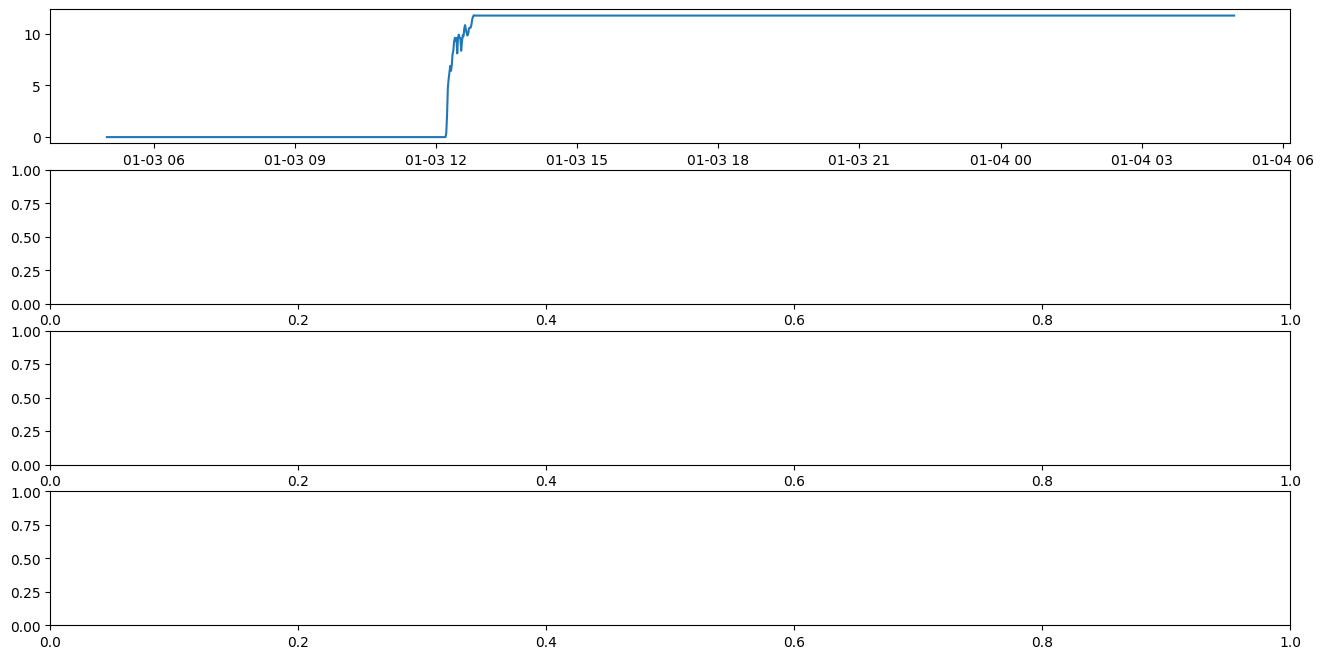

In [414]:
algo.jitter_recovery.research.investigate_trading(dfst_feature_approximate, dfst_trading)

<Axes: xlabel='timestamp'>

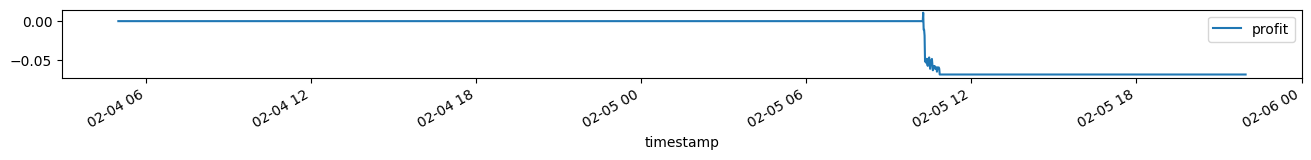

In [86]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

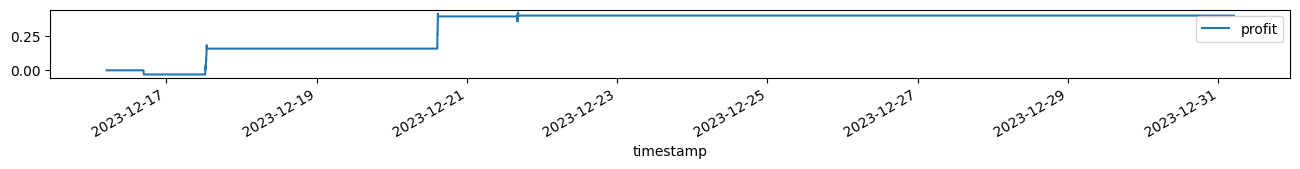

In [28]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

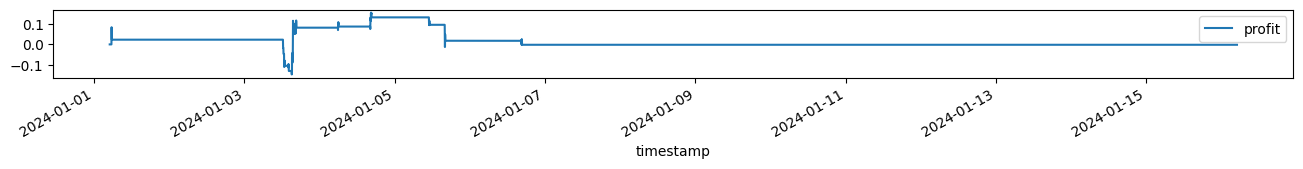

In [42]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

<Axes: xlabel='timestamp'>

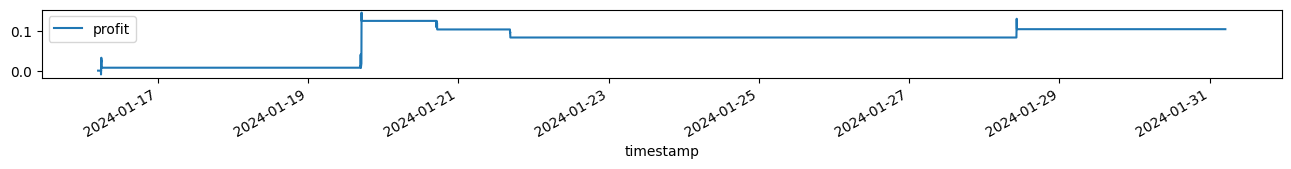

In [175]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(16,1))

In [220]:
dfst_trading[['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
DMAIL-USDT-SWAP,-0.003662
1INCH-USD-SWAP,0.000000
MKR-USDT-SWAP,0.000000
MOVR-USDT-SWAP,0.000000
NEAR-USDT-SWAP,0.000000
...,...
ETHW-USDT-SWAP,0.000000
FET-USDT-SWAP,0.000000
FIL-USDT-SWAP,0.000000


In [1]:
#dfst_feature.xs('FITFI-USDT-SWAP').loc['2023-12-07 16:38:00']

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < -0.01)]

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < 0)].loc[symbol_with_jumps[0]]

In [415]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:12:00, MATIC-USDT-SWAP, 0.8041, position_changed: 1.0
2024-01-03 12:12:00, QTUM-USDT-SWAP, 2.958, position_changed: 1.0
2024-01-03 12:12:00, GMT-USDT-SWAP, 0.2732, position_changed: 1.0
2024-01-03 12:12:00, LDO-USDT-SWAP, 2.631, position_changed: 1.0
2024-01-03 12:12:00, PEPE-USDT-SWAP, 1.11e-06, position_changed: 1.0
2024-01-03 12:12:00, CELO-USDT-SWAP, 0.698, position_changed: 1.0
2024-01-03 12:12:00, HBAR-USDT-SWAP, 0.08034, position_changed: 1.0
2024-01-03 12:12:00, BIGTIME-USDT-SWAP, 0.3228, position_changed: 1.0
2024-01-03 12:12:00, ACE-USDT-SWAP, 7.74, position_changed: 1.0
2024-01-03 12:12:00, SOL-USDT-SWAP, 90.9, position_changed: 1.0
2024-01-03 12:12:00, PYTH-USDT-SWAP, 0.2263, position_changed: 1.0
2024-01-03 12:12:00, CTC-USDT-SWAP, 0.5743, position_changed: 1.0
2024-01-03 12:12:00, NEAR-USDT-SWAP, 3.182, position_changed: 1.0
2024-01-03 12:12:00, ORDI-USDT-SWAP, 69.455, position_changed: 1.0
2024-01-03 12:12:00, ARB-USDT-SWAP, 1.6391, position_changed: 1.0
20

## single symobl

In [373]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)

<module 'algo.jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research.py'>

In [374]:
symbol_investigate = 'GAL-USDT-SWAP'
dfs = dfi.xs(symbol_investigate, level=1)

In [375]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(40), 
    0.20, -0.04, 0.02, is_long_term=False)

in_position: 1, value_at_enter: 1.905, lowest_since_enter: 1.905, timedelta_since_position_enter: 0, v_ch_max_is_to_when_enter: 1.971, v_ch_min_is_to_when_enter: 1.905, v_ch_max_is_from_when_enter: 1.788, v_ch_min_is_from_when_enter: 1.971, ch_from_enter: 0, ch_from_lowest_since_enter: 0
trading_param:
jitter_recovery_feature_param: <numba.experimental.jitclass.boxing.JitterRecoveryFeatureParam object at 0x7fab555993c0>, jump_threshold: 0.05, drop_from_jump_threshold: -0.03, exit_jumpt_threshold: 0.01, is_long_term: False
features:
0.10234899328859064, -0.03348554033485543, 6.0, 0.006422815104427623


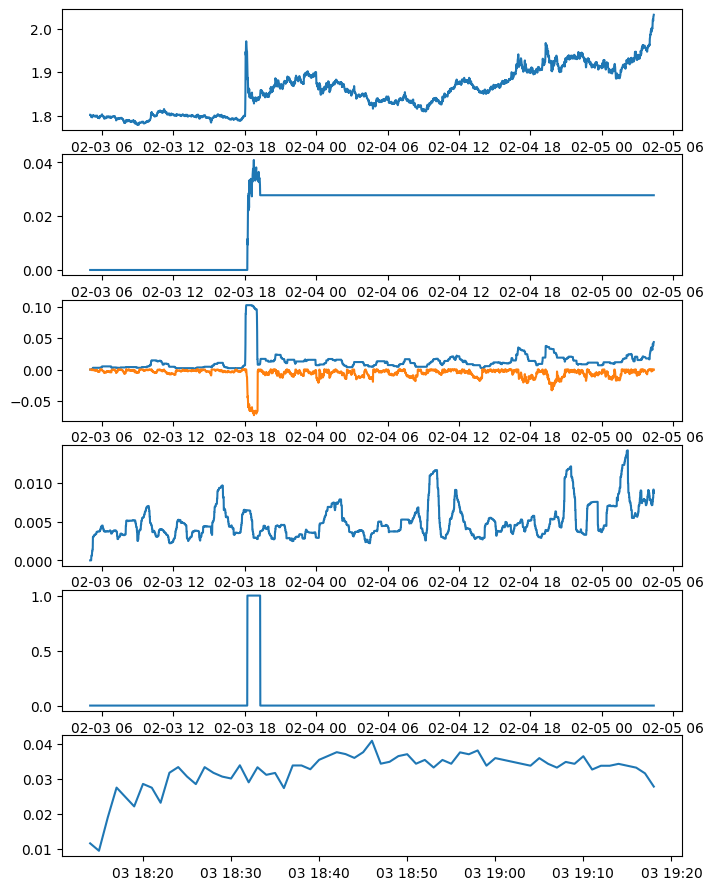

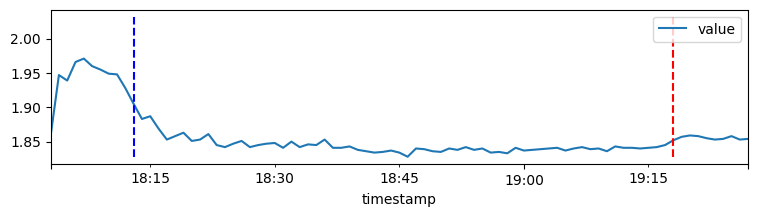

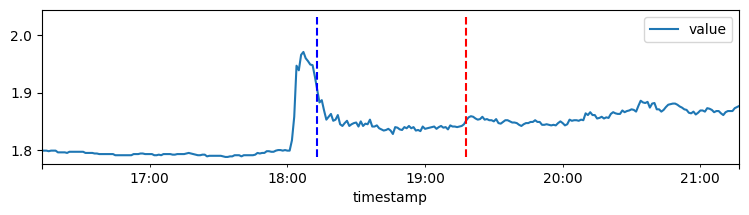

In [377]:
df_feature, df_trading = algo.jitter_recovery.research.investigate_symbol(df, df_collective_feature_approxiamate, symbol_investigate, jitter_recovery_trading_param, figsize=(8, 11))

In [378]:
df_trading[
    (df_trading.index >=  '2024-01-03 12:14:00') &
    (df_trading.index <=  '2024-01-03 12:18:00')
]

,avg_v_before_max_ch,avg_v_before_min_ch,ch,ch_max,ch_min,ch_since_max,ch_since_min,distance_max_ch,distance_min_ch,v_ch_max_is_from,...,timedelta_since_position_enter,v_ch_max_is_to_when_enter,v_ch_min_is_to_when_enter,v_ch_max_is_from_when_enter,v_ch_min_is_from_when_enter,ch_from_enter,ch_from_lowest_since_enter,position_changed,profit_raw,profit
timestamp,,,,,,,,,,,,,,,,,,,,,


In [146]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-01-03 12:27:00,1.7395,1,1.0,0.000,0.000000
2024-01-03 12:29:00,1.8060,0,-1.0,-0.016,-0.008939


In [147]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:27:00, ARB-USDT-SWAP, 1.7395, position_changed: 1.0
2024-01-03 12:28:00, ARB-USDT-SWAP, 1.79, position_changed: -1.0
